<a href="https://colab.research.google.com/github/Gouravsharm1/microgrid_stability_using_ann/blob/main/microgrid_stability_btp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving smart_grid_stability_augmented.csv to smart_grid_stability_augmented.csv
User uploaded file "smart_grid_stability_augmented.csv" with length 14244781 bytes


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

In [6]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [7]:
data = pd.read_csv('smart_grid_stability_augmented.csv')


In [8]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [9]:
map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

In [10]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
2191,3.879024,5.297912,6.193792,5.257825,4.050490,-1.140084,-1.093092,-1.817314,0.499645,0.209390,0.940356,0.110423,0.030742,0
36929,7.724162,5.269625,2.691429,7.505064,4.259048,-1.143711,-1.512459,-1.602878,0.635034,0.064074,0.177766,0.853767,0.037056,0
58000,5.306905,5.414825,2.452792,4.964973,2.853706,-1.391630,-0.952709,-0.509366,0.160440,0.867021,0.958669,0.183520,0.026496,0
25891,8.546713,6.614096,4.693043,6.885252,3.486896,-0.559983,-1.254840,-1.672073,0.586416,0.258332,0.494629,0.317367,0.031312,0
8124,0.777448,3.394806,2.545038,3.147868,3.935951,-0.710561,-1.423838,-1.801552,0.487127,0.718192,0.981522,0.883980,0.056089,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


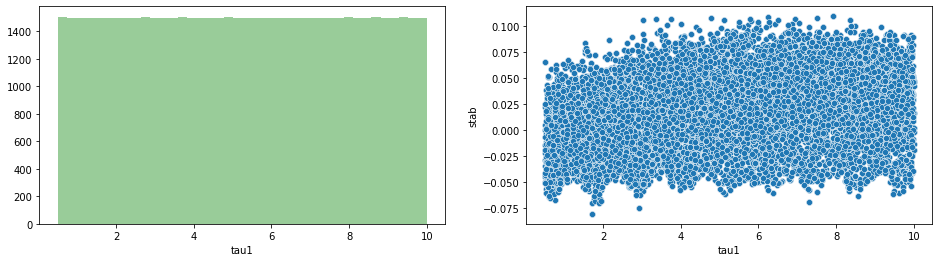

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


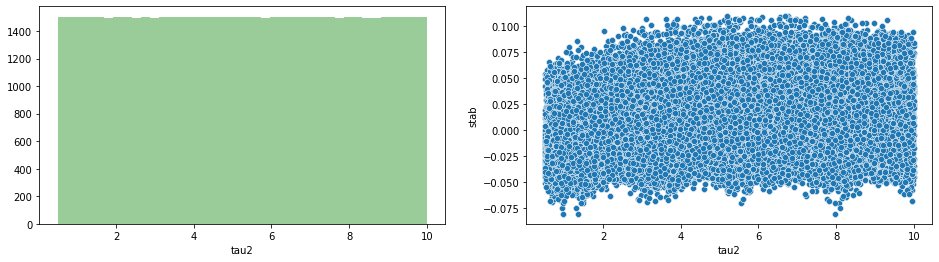

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


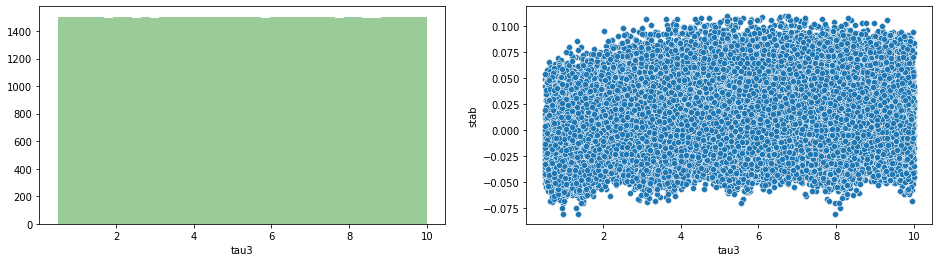

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


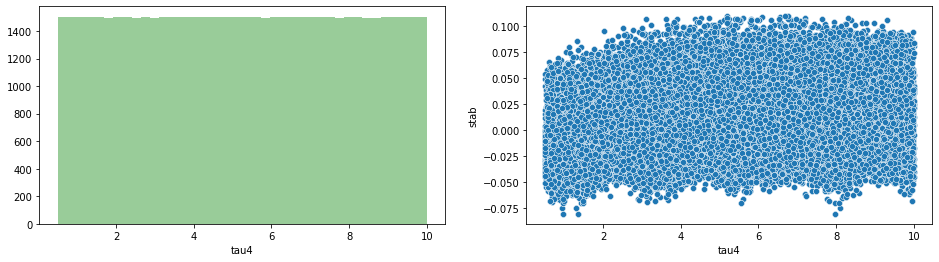

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


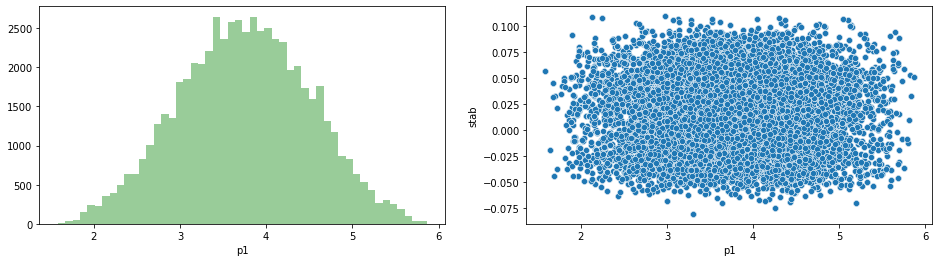

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


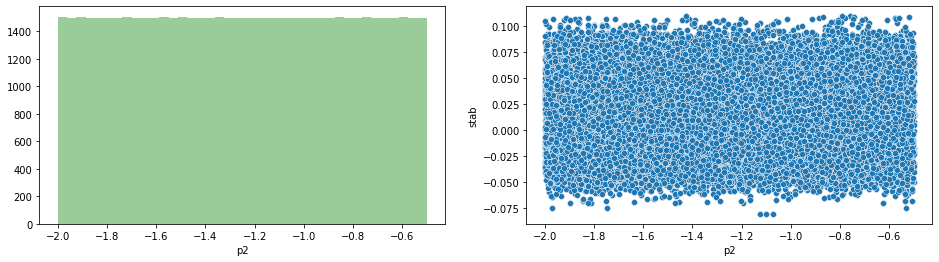

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


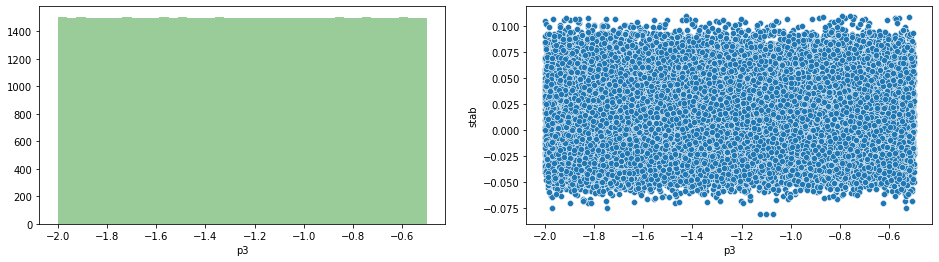

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


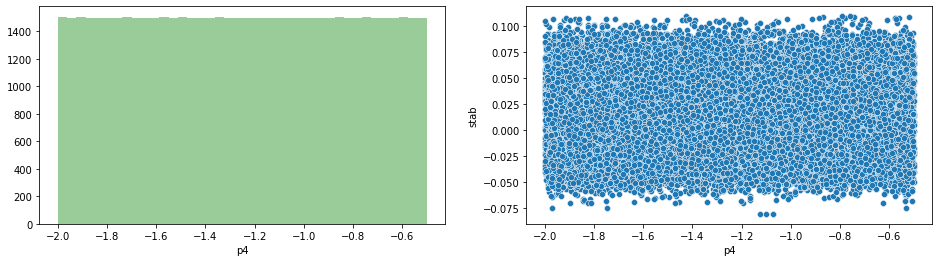

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


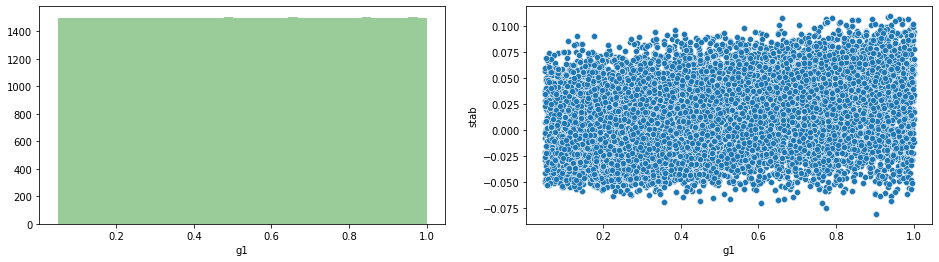

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


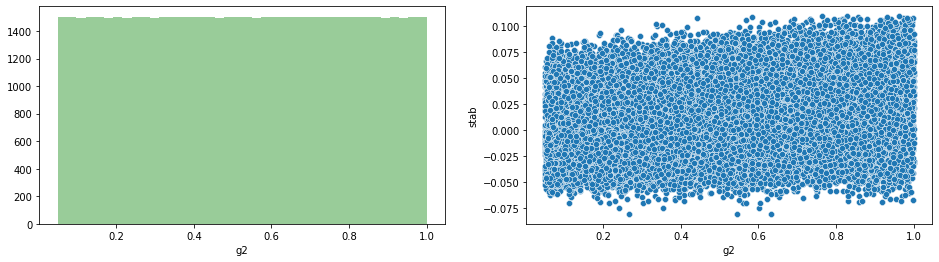

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


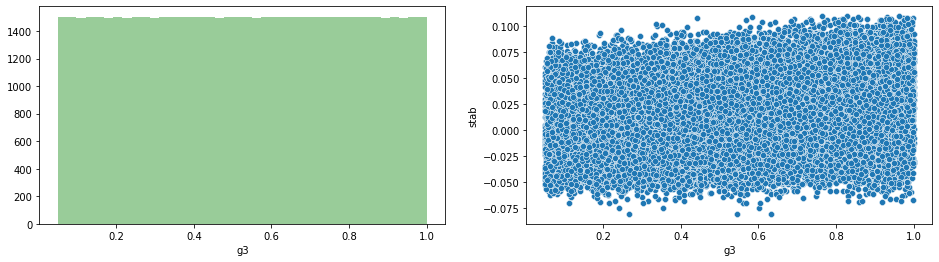

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


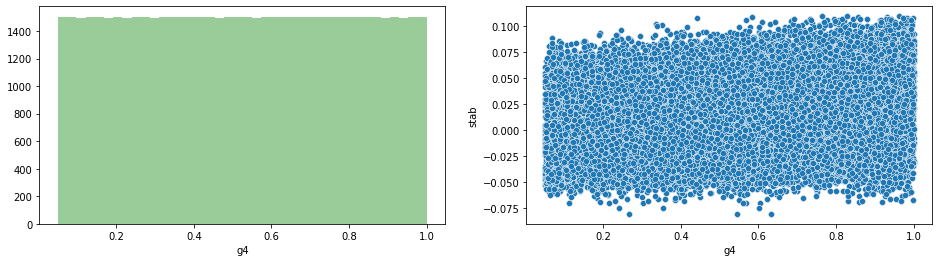

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


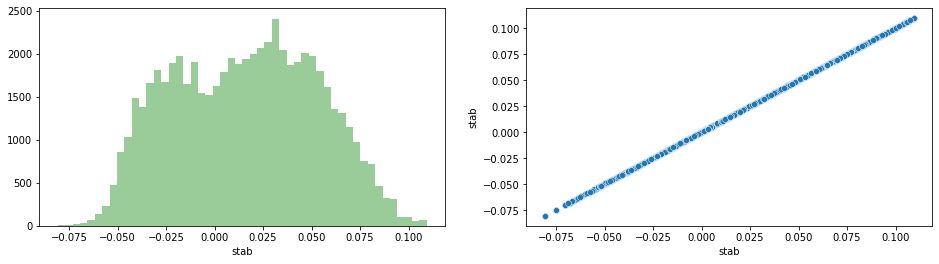

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


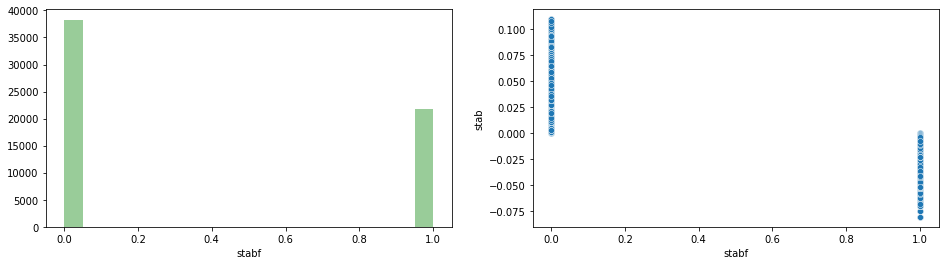

In [11]:
for column in data.columns:
    assessment(data, 'stab', column, -1)

In [12]:
data.p1.skew()

-0.012688423269883488

In [13]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


hence 63.8 percent are unstable distribution and remaining 36.2 percent are stable

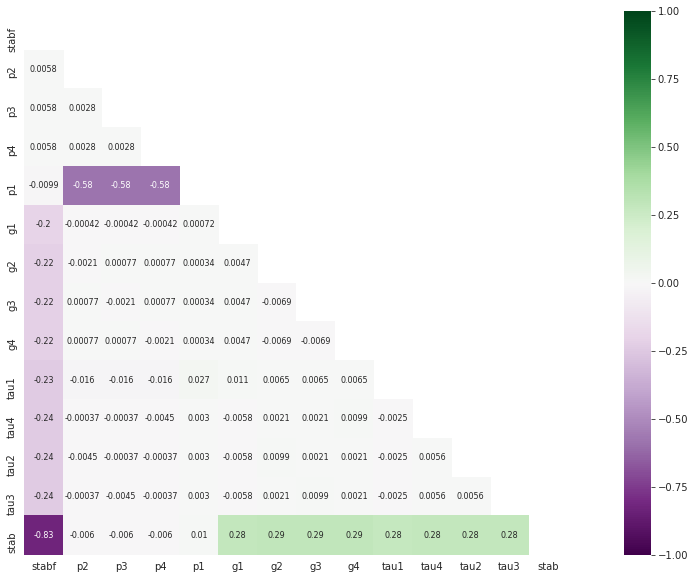

In [14]:
correlation_map(data, 'stabf', 14)

In [15]:
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(0    0.638296
 1    0.361704
 Name: stabf, dtype: float64, 0    0.635333
 1    0.364667
 Name: stabf, dtype: float64)

In [16]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

In [17]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

using Random Forest Classifier model

In [33]:
rfm= RFC(n_estimators=70 , oob_score=True , n_jobs=-1, random_state=101, max_features=None , min_samples_leaf=30)
rfm.fit(X_training,y_training)
y_pred1= rfm.predict(X_testing)

In [34]:
y_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
y_pred1[y_pred1 <= 0.5] = 0
y_pred1[y_pred1 > 0.5] = 1

In [36]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred1, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3558,254
Actual Stable,315,1873


In [37]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 90.52%


In [38]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  

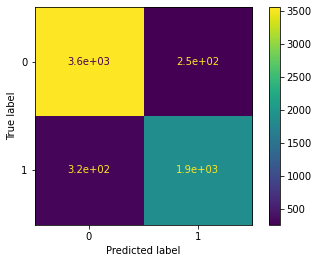

In [39]:
plot_confusion_matrix(rfm, X_testing, y_testing)  

In [32]:
plt.show()

In [ ]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))

classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(5, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

338/338 [==============================] - 0s 911us/step - loss: 0.0692 - accuracy: 0.9713
Round 1 - Loss: 0.0692 | Accuracy: 97.13 %
338/338 [==============================] - 0s 952us/step - loss: 0.0688 - accuracy: 0.9707
Round 2 - Loss: 0.0688 | Accuracy: 97.07 %
338/338 [==============================] - 0s 913us/step - loss: 0.0657 - accuracy: 0.9745
Round 3 - Loss: 0.0657 | Accuracy: 97.45 %
338/338 [==============================] - 0s 889us/step - loss: 0.0531 - accuracy: 0.9782
Round 4 - Loss: 0.0531 | Accuracy: 97.82 %
338/338 [==============================] - 0s 928us/step - loss: 0.0474 - accuracy: 0.9801
Round 5 - Loss: 0.0474 | Accuracy: 98.01 %


In [ ]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3696,71
Actual Stable,59,2174


In [ ]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.83%
